**Download the data using wget and unpack it**

In [ ]:
!wget https://github.com/gulvarol/grocerydataset/releases/download/1.0/GroceryDataset_part1.tar.gz


In [ ]:
!wget https://github.com/gulvarol/grocerydataset/releases/download/1.0/GroceryDataset_part2.tar.gz

In [ ]:
!tar -xvzf GroceryDataset_part1.tar.gz

In [ ]:
!tar -xvzf GroceryDataset_part2.tar.gz

**DATA PREPARATION**

In [6]:
import cv2
import pandas as pd
from matplotlib import pyplot as plt
import os
import numpy as np
from sklearn.model_selection import train_test_split
%matplotlib inline

In [7]:
data_path = '/'
# we'll use data from two folders
shelf_images = 'ShelfImages/'
product_images = 'ProductImagesFromShelves/'

**Split the file name is to get the file_name, shelf_id and planogram_id and other required fields**

In [8]:
# let's get all shelves photo data from ShelfImages
jpg_files = [f for f in os.listdir(f'{shelf_images}') if f.endswith('JPG')]
photos_df = pd.DataFrame([[f, f[:6], f[7:14]] for f in jpg_files], 
                         columns=['file', 'shelf_id', 'planogram_id'])
photos_df.head()

,file,shelf_id,planogram_id
0,C1_P09_N1_S5_1.JPG,C1_P09,N1_S5_1
1,C1_P09_N3_S3_1.JPG,C1_P09,N3_S3_1
2,C1_P04_N1_S4_1.JPG,C1_P04,N1_S4_1
3,C1_P07_N2_S3_2.JPG,C1_P07,N2_S3_2
4,C2_P04_N2_S4_1.JPG,C2_P04,N2_S4_1


In [9]:
# let's get products on shelves photo from ProductImagesFromShelves
products_df = pd.DataFrame(
    [[f[:18], f[:6], f[7:14], i, *map(int, f[19:-4].split('_'))] 
     for i in range(11) 
     for f in os.listdir(f'{product_images}{i}') if f.endswith('png')],
    columns=['file', 'shelf_id', 'planogram_id', 
             'category', 'xmin', 'ymin', 'w', 'h'])
# convert from width height to xmax, ymax
products_df['xmax'] = products_df['xmin'] + products_df['w']
products_df['ymax'] = products_df['ymin'] + products_df['h']
products_df.head()


,file,shelf_id,planogram_id,category,xmin,ymin,w,h,xmax,ymax
0,C1_P01_N1_S2_1.JPG,C1_P01,N1_S2_1,0,280,1568,252,376,532,1944
1,C1_P08_N2_S4_1.JPG,C1_P08,N2_S4_1,0,1248,164,272,356,1520,520
2,C4_P07_N1_S4_2.JPG,C4_P07,N1_S4_2,0,320,616,168,304,488,920
3,C4_P08_N2_S2_1.JPG,C4_P08,N2_S2_1,0,88,900,232,332,320,1232
4,C3_P06_N2_S3_2.JPG,C3_P06,N2_S3_2,0,1744,1032,256,420,2000,1452


**Split the  data for Train, Test and Validation**

In [10]:
# get distinct shelves
shelves = list(set(photos_df['shelf_id'].values))
# use train_test_split from sklearn
shelves_train, shelves_validation, _, _ = train_test_split(
    shelves, shelves, test_size=0.3, random_state=6)
# mark all records in data frames with is_train flag
def is_train(shelf_id): return shelf_id in shelves_train
photos_df['is_train'] = photos_df.shelf_id.apply(is_train)
products_df['is_train'] = products_df.shelf_id.apply(is_train)

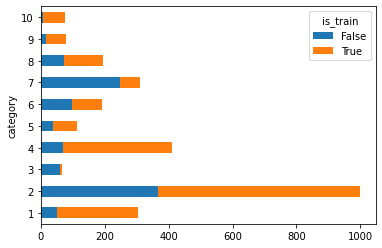

In [11]:
df = products_df[products_df.category != 0].\
         groupby(['category', 'is_train'])['category'].\
         count().unstack('is_train').fillna(0)
df.plot(kind='barh', stacked=True)

In [50]:
photos_df.head()

,file,shelf_id,planogram_id,is_train
0,C1_P09_N1_S5_1.JPG,C1_P09,N1_S5_1,True
1,C1_P09_N3_S3_1.JPG,C1_P09,N3_S3_1,True
2,C1_P04_N1_S4_1.JPG,C1_P04,N1_S4_1,True
3,C1_P07_N2_S3_2.JPG,C1_P07,N2_S3_2,True
4,C2_P04_N2_S4_1.JPG,C2_P04,N2_S4_1,True


In [51]:
products_df.head()

,file,shelf_id,planogram_id,category,xmin,ymin,w,h,xmax,ymax,is_train
0,C1_P01_N1_S2_1.JPG,C1_P01,N1_S2_1,0,280,1568,252,376,532,1944,False
1,C1_P08_N2_S4_1.JPG,C1_P08,N2_S4_1,0,1248,164,272,356,1520,520,True
2,C4_P07_N1_S4_2.JPG,C4_P07,N1_S4_2,0,320,616,168,304,488,920,True
3,C4_P08_N2_S2_1.JPG,C4_P08,N2_S2_1,0,88,900,232,332,320,1232,True
4,C3_P06_N2_S3_2.JPG,C3_P06,N2_S3_2,0,1744,1032,256,420,2000,1452,True


In [48]:
# save to pkl
photos_df.to_pickle(f'{data_path}/content/drive/MyDrive/Paralleldots/photos.pkl')
products_df.to_pickle(f'{data_path}/content/drive/MyDrive/Paralleldots/products.pkl')

In [13]:
os.listdir()

['.config',
 'ProductImagesFromShelves',
 'ShelfImages',
 'BrandImages',
 'photos.pkl',
 'BrandImagesFromShelves',
 'products.pkl',
 'GroceryDataset_part2.tar.gz',
 'ProductImages',
 'GroceryDataset_part1.tar.gz',
 'sample_data']

In [14]:
# function to display shelf photo with rectangled products
def draw_shelf_photo(file):
    file_products_df = products_df[products_df.file == file]
    coordinates = file_products_df[['xmin', 'ymin', 'xmax', 'ymax']].values
    im = cv2.imread(f'{shelf_images}{file}')
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)    
    for xmin, ymin, xmax, ymax in coordinates:
        cv2.rectangle(im, (xmin, ymin), (xmax, ymax), (0, 255, 0), 5)
    plt.imshow(im)

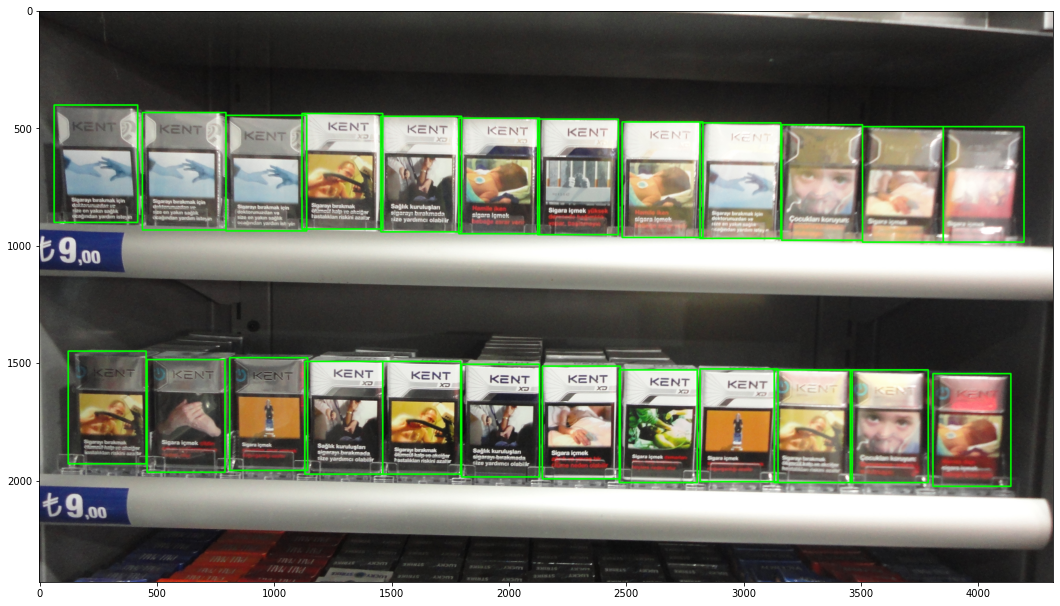

In [15]:
# draw one photo to check our data
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
draw_shelf_photo('C3_P07_N1_S2_1.JPG')